In [1]:
"""
plots for all by all lasso where labels are permuted

Shaina Lu
June 2020
Zador & Gillis Labs
"""

'\nplots for all by all lasso where labels are permuted\n\nShaina Lu\nJune 2020\nZador & Gillis Labs\n'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

In [3]:
#function for matplotlib formatting
def set_style():
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# Read in Data

In [4]:
#infiles
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"

In [5]:
ontology = pd.read_csv(ONTOLOGY_PATH)
ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
ontology = ontology.fillna(-1)  #make root's parent -1

In [6]:
STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')

# Heatmap Plotting Functions

__upper triangular heat map__

In [7]:
def uppertriheatmap(allbyall):
    """get a first look at allbyall outfiles by visualizing as heat map"""
    plt.rcParams['figure.figsize'] = [10,10]
    sns.set()
    mask = np.zeros_like(allbyall)   #zero matrix of size allbyall
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(allbyall, mask=mask, square=True, vmax=1, vmin=0)
        
    plt.show()

__cluster map code__

In [8]:
def clustermap(allbyall, ontology, filename):
    """create clustermap for given all by all"""
    #copy uppertriangular to lower triangular
    allbyall2 = allbyall
    allbyall2 = allbyall.fillna(0, inplace=False)
    temp = allbyall2.T
    allbyall2 = allbyall2.values  #convert to numpy
    temp = temp.values
    allbyall2[np.tril_indices_from(allbyall)] = temp[np.tril_indices_from(allbyall)]
    #are there any missing values in duplicated matrix?
    print("are there any missing values after copying over diagonal?")
    print(np.isnan(allbyall2).any())
    
    #color bar code to get rows indicated by region in cluster map
    #areas: CTX (incl hippo), CNU (striatum and pallidum),
    #IB (thalamus + hypothalamus), MB, HB, and CB (Cerebellum)
    #first get id's and allen color for these areas
    acros = ["CTX", "CNU", "IB", "MB", "HB", "CB", "root"]
    areaids = []
    allencolor = []
    for area in acros:
        areaids.append(ontology.loc[ontology.acronym == area, "id"].values[0])
        allencolor.append(ontology.loc[ontology.acronym == area, "allencolor"].values[0])
        
    #propogate brain areas up to sup structure for index
    supstrucs = []
    for area in list(allbyall):
        while int(area) not in areaids:
            area = int(ontology.loc[ontology.id==int(area),"parent"])
        supstrucs.append(int(area))
        
    #create color map for cluster map
    cbarmap = dict(zip(areaids,allencolor))
    row_colors = pd.Series(supstrucs).map(cbarmap)
    row_colors.name = " " #no name so it can be centered below
    row_colors.index = list(allbyall)

    #use a dataframeinstead for the colorbar 
    #to get wider colorbar by tricking multi-level labels
    row_colors_df = pd.DataFrame(row_colors)
    for i in range(10):
        if i == 5:
            row_colors_df["main brain areas"] = row_colors
            continue
        row_colors_df[" "*i] = row_colors
    
    #clustering using inverse of AUROC as distance
    #I think this is the correct one
    allbyall2_df = pd.DataFrame(allbyall2)
    allbyall2_df.set_index(pd.Index(list(allbyall)), inplace=True)
    allbyall2_df.index.name = "all brain areas"
    allbyall2_df.columns = list(allbyall)
    allbyall2_df.columns.name = "all brain areas"

    #use re-centered AUROC as similarity metric
    distm = np.abs(allbyall2_df - 0.5)        #center the aurocs at 0.5, get abs value
    np.fill_diagonal(distm.values, 0)         #force diagonal to be 0, required for linkage
    linkage = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(distm), method='average')

    #plot parameters
    plt.rcParams['figure.figsize'] = [10,10]
    sns.set(font_scale=1.25)

    g = clustmap = sns.clustermap(allbyall2_df, row_linkage=linkage, col_linkage=linkage,\
                                  square=True, xticklabels=False, yticklabels=False, vmax=1,\
                                  row_colors=row_colors_df, cbar_kws={'label': 'AUROC'})
    #legend hack
    legend_dict = dict(zip(acros, allencolor))
    for label in legend_dict.keys():
        g.ax_col_dendrogram.bar(0, 0, color=legend_dict[label],
                                label=label, linewidth=0)
        g.ax_col_dendrogram.legend(loc=[0,1], ncol=3, title="main brain areas")
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

__upper triangular histogram code__

In [9]:
def uppertrihist(allbyall, xaxislab, ylimflag, ylim1, ylim2, filename):
    """histogram of upper triangular of heatmaps"""
    allbyall = allbyall.values #convert to numpy
    histdata = allbyall[np.triu_indices_from(allbyall,k=1)]
    print("number of 0's in upper triangular: %d" %(len(np.where(histdata == 0)[0])))
    histdata = histdata[histdata != 0] #remove 0's
    
    #plot
    set_style()
    plt.hist(histdata, bins=100)
    plt.xlabel(xaxislab)
    plt.ylabel("counts")
    plt.axvline(x=np.mean(histdata), c="black", linestyle='--')
    plt.xlim([0,1.02])
    if ylimflag == 1:
        plt.ylim([ylim1,ylim2])
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    #mean AUROC for upper triangular
    print("mean AUROC for upper triangular: %f" %(np.mean(histdata)))

# ST permuted

In [10]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallST0p1permute_train0628.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallST0p1permute_test0628.csv"

In [11]:
train_allbyall = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall = train_allbyall.set_index(train_allbyall.columns)

test_allbyall = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall = test_allbyall.set_index(test_allbyall.columns)

train set


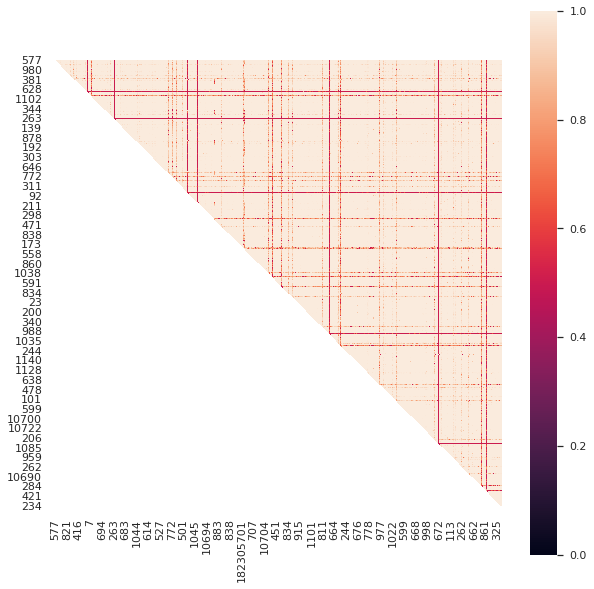

test set


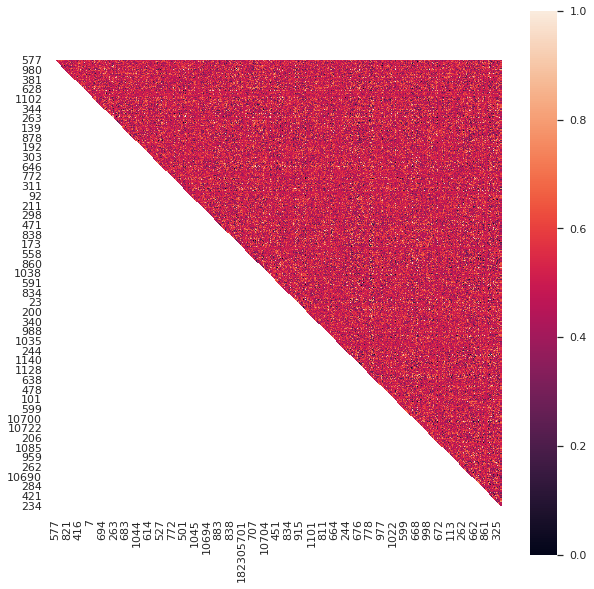

In [12]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall)
print("test set")
uppertriheatmap(test_allbyall)

are there any missing values after copying over diagonal?
False


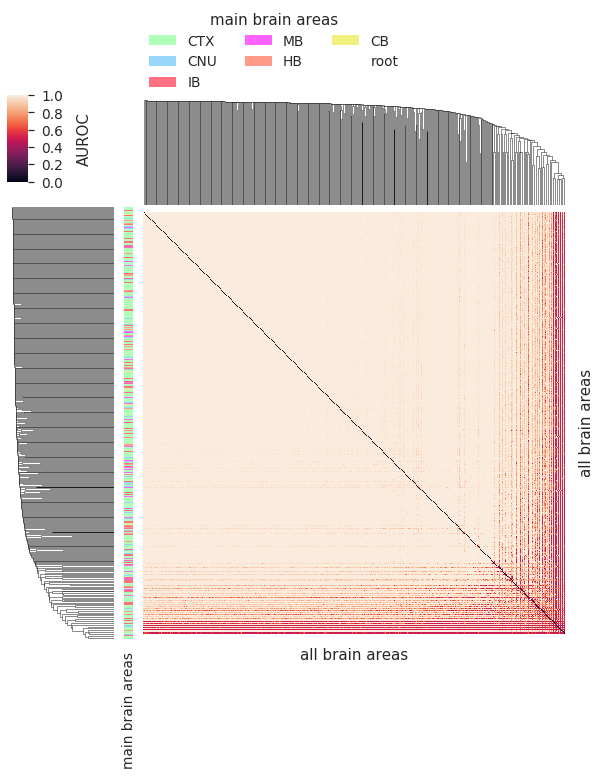

are there any missing values after copying over diagonal?
False


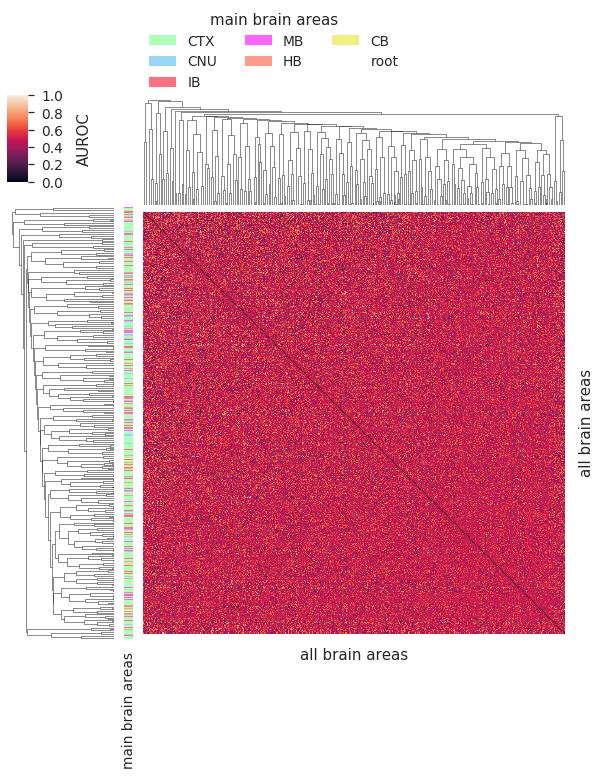

In [13]:
#clustermaps
clustermap(train_allbyall, ontology, "063020_3.png")
clustermap(test_allbyall, ontology, "063020_4.png")

number of 0's in upper triangular: 0


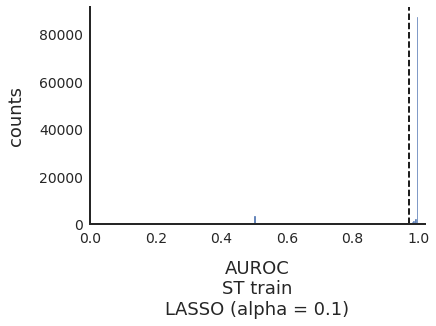

mean AUROC for upper triangular: 0.970134
number of 0's in upper triangular: 55


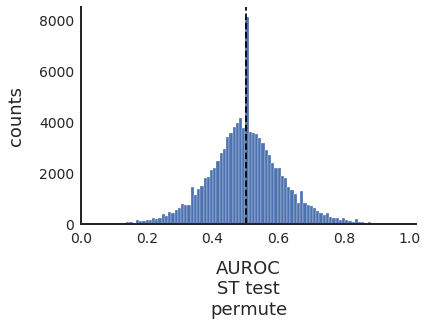

mean AUROC for upper triangular: 0.501324


In [14]:
#upper triangular histogram
uppertrihist(train_allbyall, "AUROC\nST train\nLASSO (alpha = 0.1)", 0, 0, 0, False)
uppertrihist(test_allbyall, "AUROC\nST test\npermute", 0, 0, 0, "063020_5.pdf")
#uppertrihist(test_allbyall, "AUROC\nST test\nLASSO (alpha = 0.1)", 1, 0, 100000, "051120_5.pdf")

# ABA permuted

In [15]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p1permute_train0628.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p1permute_test0628.csv"

In [16]:
train_allbyall = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall = train_allbyall.set_index(train_allbyall.columns)

test_allbyall = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall = test_allbyall.set_index(test_allbyall.columns)

train set


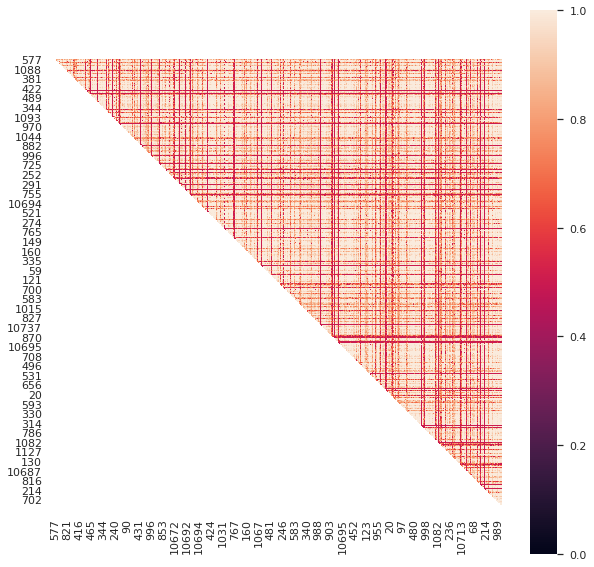

test set


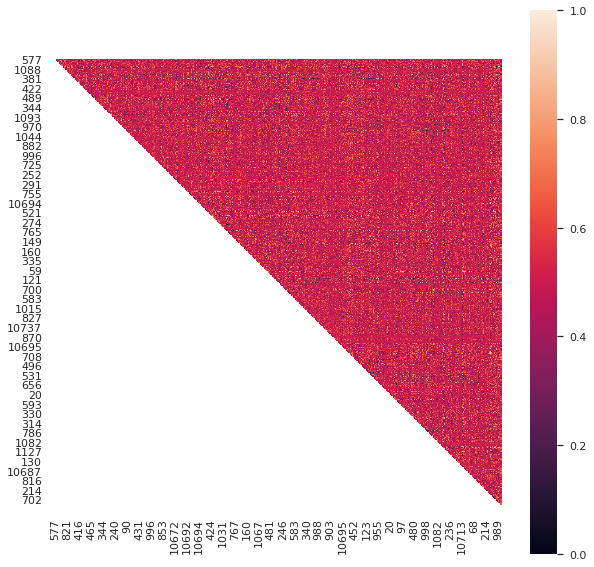

In [17]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall)
print("test set")
uppertriheatmap(test_allbyall)

are there any missing values after copying over diagonal?
False


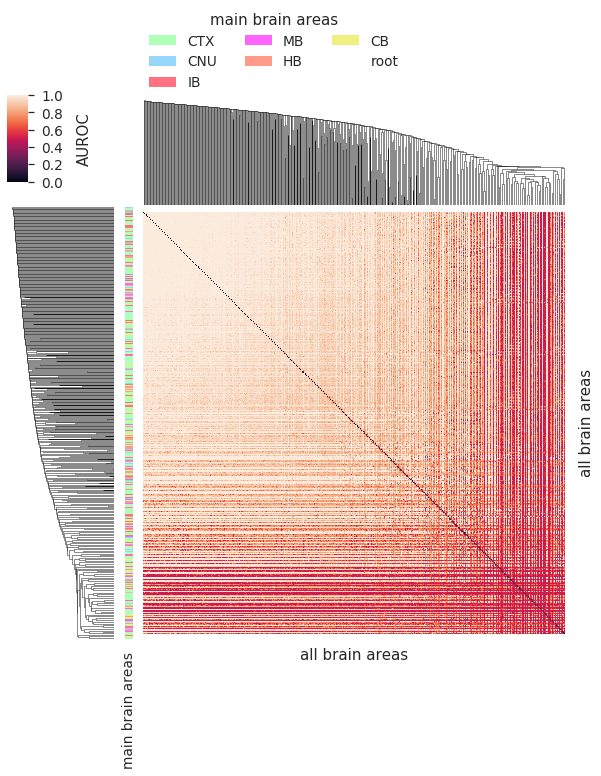

are there any missing values after copying over diagonal?
False


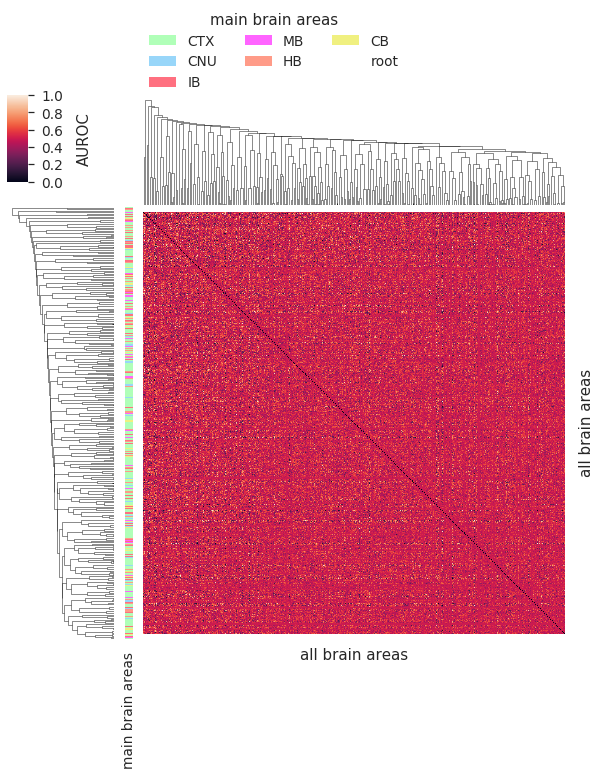

In [18]:
#clustermaps
clustermap(train_allbyall, ontology, "063020_6.png")
clustermap(test_allbyall, ontology, "063020_7.png")

number of 0's in upper triangular: 0


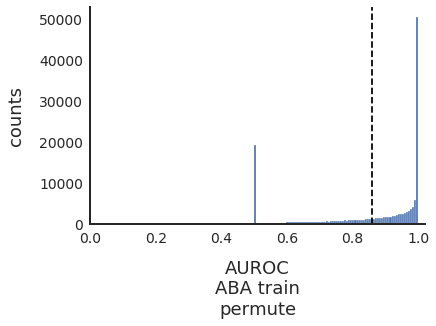

mean AUROC for upper triangular: 0.857973
number of 0's in upper triangular: 43


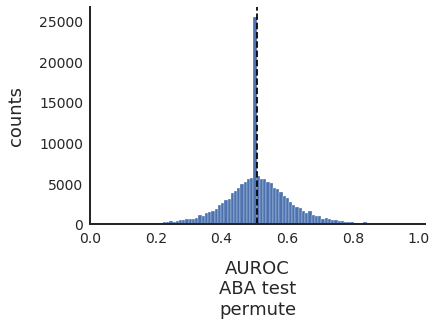

mean AUROC for upper triangular: 0.509551


In [19]:
#upper triangular histogram
uppertrihist(train_allbyall, "AUROC\nABA train\npermute", 0, 0, 0, False)
uppertrihist(test_allbyall, "AUROC\nABA test\npermute", 0, 0, 0, "063020_8.pdf")